In [1]:
import numpy as np
import numpy.random as rand
from collections import Counter
from scipy.interpolate import Rbf
from sklearn.manifold import TSNE

import glob
import time

import matplotlib.pyplot as plt
import seaborn as sns

# Import EQAPOL Normal Flow Data

In [2]:
# input the value
tmp_dir = "/data/deep-learning-group/test_data/flow_EQAPOL/"
fname_Costim = "data_Costim.np"
fname_CMV    = "data_CMV.np"
fname_SEB    = "data_SEB.np"

# open and write the file
file_object = open(tmp_dir + fname_Costim, 'rb')
data_Costim = np.load(file_object)
file_object.close()

file_object = open(tmp_dir + fname_CMV, 'rb')
data_CMV = np.load(file_object)
file_object.close()

file_object = open(tmp_dir + fname_SEB, 'rb')
data_SEB = np.load(file_object)
file_object.close()

file_object = open(tmp_dir + "markers.np", 'rb')
markers = np.load(file_object)
markers_dict = {items[1]: idx for idx, items in enumerate(markers)}
file_object.close()

print("The data are input.")

The data are input.


In [3]:
samples      = np.array(list(data_Costim) + list(data_CMV) + list(data_SEB))
label_groups = np.array(            \
    [0] * len(list(data_Costim)) +  \
    [1] * len(list(data_CMV)) +     \
    [2] * len(list(data_SEB)))
    
print("check dimension")
print("================")
print("Labels:  ", label_groups.shape)
print(Counter(label_groups))
print("================")
print("Samples: ", samples.shape)
print("Samples: ", samples[0].shape)
print("Samples: ", samples[1].shape)
print("================")
print("Costim: ", data_Costim.shape)
print("Costim: ", data_Costim[0].shape)
print("Costim: ", data_Costim[1].shape)
print("================")
print("CMV:    ", data_CMV.shape)
print("CMV:    ", data_CMV[0].shape)
print("CMV:    ", data_CMV[1].shape)
print("================")
print("SEB:    ", data_SEB.shape)
print("SEB:    ", data_SEB[0].shape)
print("SEB:    ", data_SEB[1].shape)

check dimension
Labels:   (33,)
Counter({0: 11, 1: 11, 2: 11})
Samples:  (33,)
Samples:  (455472, 14)
Samples:  (607410, 14)
Costim:  (11,)
Costim:  (455472, 14)
Costim:  (607410, 14)
CMV:     (11,)
CMV:     (411894, 14)
CMV:     (515178, 14)
SEB:     (11,)
SEB:     (422658, 14)
SEB:     (519426, 14)


# Check Dimension

```
res = np.vstack(samples)
mu = np.mean(res, axis=0)
sd = np.std( res, axis=0)
print(res.shape)
print(mu)
print(sd)
```

In [5]:
shapes     = np.array([sample.shape    for sample in samples])
shapes_ax1 = np.array([sample.shape[0] for sample in samples])
shapes_ax2 = np.array([sample.shape[1] for sample in samples])

In [6]:
shapes.shape

(33, 2)

In [7]:
len(shapes.shape) - 1 + shapes.shape[1]

3

In [8]:
# events
shapes_ax1

array([455472, 607410, 415332, 444294, 529668, 529506, 492696, 513288,
       477522, 194040, 520632, 411894, 515178, 432342, 353088, 547506,
       468342, 490104, 455220, 385956, 442674, 497898, 422658, 519426,
       529902, 405180, 593892, 418536, 481482, 502794, 294426, 440982,
       495306])

In [9]:
# markers
shapes_ax2

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

# Convert flow data to image

Note: image normalization is added to the function create_img

In [10]:
def check_dimension(samples):
    """ Check the dimension of an numpy array, the function 
    allows different number of the second dimention
    
    For example:
        len(shapes.shape) = 2 && shapes.shape[1] = 2
        => result: 2 - 1 + 2 = 3
    
    >>> import numpy as np
    >>> arr = np.array([[[1], [2]], [[3], [4]]])
    >>> arr.shape
    (2, 2, 1)
    >>> check_dimension(arr)
    (3, 'Wrong input dimension; Expected 3 but 3 given; the samples should contain (samples, events, markers)')
    
    >>> x = np.array([[11, 12, 13], [14, 15, 16]])
    >>> y = np.array([[21, 22, 23], [24, 25, 26], [27, 28, 29]])
    >>> z = np.array([[31, 32, 33]])
    >>> arr = np.array([x, y, z])
    >>> check_dimension(arr)
    (3, 'Wrong input dimension; Expected 3 but 3 given; the samples should contain (samples, events, markers)')
    """
    shapes = np.array([sample.shape for sample in samples])
    checked_value = len(shapes.shape) - 1 + shapes.shape[1] 
    
    error_message = \
        "Wrong input dimension; Expected 3 but " + str(checked_value) + \
        " given; the samples should contain (samples, events, markers)"
        
    return checked_value, error_message

################################################################################

def data_standardization(samples, idx_sample = 0, verbose = False):
    """standardized features of all samples using one group of samples
    
    Position arguments:
    samples    --- numpy array; (num_samples_tot, num_cells_tot, num_features)
                   note: the num_cells_tot is not fixed for each samples
    idx_sample --- int; which sample is used for standardization; default to 0
    
    Keyword arguments:
    verbose --- print out the running process
    """
    
    if (verbose):
        print("Data Standardization...")
    
    # num_samples_tot, num_cells_tot, num_features
    # => correct value: len(shapes.shape) = 2 && shapes.shape[1] = 2
    checked_value, error_message = check_dimension(samples)
    assert (checked_value == 3), error_message
    assert samples.shape[0] > idx_sample, "Incorrect input of idx_sample"
    
    # calculate mu and sd
    res = samples[idx_sample] 
    mu  = np.mean(res, axis=0)
    sd  = np.std( res, axis=0)
    
    # standardize
    samples_stdard = np.array( [(sample - mu) / sd for sample in samples] )    
    
    if (verbose):
        print("...Finish")
        
    return(samples_stdard)

##############################################################################

def data_subsetting(samples, label_groups, k = 1000, num_subsets = 10, rand_seed = 0, verbose = False):
    """create subsets for each sample
    
    Position arguments:
    samples      --- numpy array; (num_samples_tot, num_cells_tot, num_features)
    label_groups --- list or numpy array; label of each sample in samples
    
    Keyword arguments:
    k           --- number of cells get from the each sample
    num_subsets --- number of subsets; each subset contain k cells
    rand_seed   --- random seed
    verbose     --- print out the running process
    """
    
    if (verbose):
        print("Data Subsetting...")
        
    # check the dimension
    checked_value, error_message = check_dimension(samples)
    assert (checked_value == 3), error_message
    
    # initialization
    #num_samples_tot, num_cells_tot, num_features = samples.shape
    num_samples_tot = samples.shape[0]
    rand.seed(rand_seed)
    result_samples = []
    result_labels  = []
    
    # iterate through all samples
    for idx_sample in range(num_samples_tot):
        
        # initialization in each loop
        sample = samples[idx_sample]
        num_cells_tot = sample.shape[0]
        num_features  = sample.shape[1]
        
        # record the corresponding label
        group  = label_groups[idx_sample]
        result_labels += ([group] * num_subsets)
        
        # generate subsets in each sample
        for _ in range(num_subsets):
            
            # choose k cells randomly
            idx = rand.permutation(num_cells_tot)[:k]
            result_samples.append(sample[idx])
              
    # convert results from list to numpy array
    result_samples = np.array(result_samples) # (num_samples_tot * num_subsets, k, num_genes)
    result_labels  = np.array(result_labels)  # (num_samples_tot * num_subsets,)
    
    if (verbose):
        print("...Finish")
    
    return result_labels, result_samples

##############################################################################

def create_tsne(samples, verbose = False,
                tsne_dimension  = 2,
                tsne_perplexity = 40, 
                tsne_iter       = 300, 
                tsne_verbose    = 0,
                tsne_rand_seed  = 0):
    """create t-SNE plot for each sample
    
    Position arguments:
    samples --- numpy array; (num_samples_tot, num_cells_tot, num_features)
    
    Keyword arguments:
    rand_seed --- random seed
    verbose   --- print out the running process
    """
    
    if (verbose):
        print("Create t-SNE plots...")
        
    # check the dimension
    checked_value, error_message = check_dimension(samples)
    assert (checked_value == 3), error_message
    
    # initialization
    num_samples_tot = samples.shape[0]
    result_tsne = []
    
    # generate tsne plot for each sample
    for idx_sample in range(num_samples_tot):
        if (verbose):
            print("\tPrepare t-SNE plot of the", idx_sample, "sample")
        
        # initialization in each loop
        sample = samples[idx_sample]
        num_cells_tot = sample.shape[0]
        num_features  = sample.shape[1]
        
        # for each sample, generate a t-SNE plot
        tsne = TSNE(n_components = tsne_dimension, 
                    verbose      = tsne_verbose, 
                    perplexity   = tsne_perplexity, 
                    n_iter       = tsne_iter, 
                    random_state = tsne_rand_seed)
        res = tsne.fit_transform(sample)
        result_tsne.append(res)
    
    # convert the result from list to numpy array
    result_tsne = np.array(result_tsne)
    
    if (verbose):
        print("...Finish")
        
    return result_tsne

##############################################################################

def create_img(tsne_plots, samples, n_grid = 128, 
               verbose = False, 
               verbose_sample = False, 
               verbose_marker = False):
    """create image from t-SNE plot
    
    Position arguments:
    tsne_plots --- numpy array; (num_samples_tot, num_cells_tot, 2)
    samples    --- numpy array; (num_samples_tot, num_cells_tot, num_features)
    
    Keyword arguments:
    n_grid  --- the dimension of image (n_grid x n_grid)
    verbose --- print out the running process
    """
    
    if (verbose):
        print("Create images from t-SNE plot...")
    
    # check the dimension
    checked_value, error_message = check_dimension(samples)
    assert (checked_value == 3), error_message
    
    # initialization
    num_samples_tot = samples.shape[0]
    result_img = []
    
    # iterate though each samples
    for idx_sample in range(num_samples_tot):
        if (verbose_sample):
            print("\tPrepare image of the", idx_sample, "sample")
        
        # initialization in each loop
        sample = samples[idx_sample]
        num_cells_tot = sample.shape[0]
        num_features  = sample.shape[1]
        
        # get x, y coordinate of a plot
        tsne_plot = tsne_plots[idx_sample]
        x = tsne_plot[:, 0]
        y = tsne_plot[:, 1]
        
        # generate a grid
        x_c = np.linspace(min(x), max(x), n_grid)
        y_c = np.linspace(min(y), max(y), n_grid)
        x_c, y_c = np.meshgrid(x_c, y_c)
        
        # each feature is a layer/channel for the plot
        # to get each layer, perform interpolation to convert tSNE plot in a image
        img = []
        for idx_feature in range(num_features):
            
            if (verbose_marker):
                print("\t\tinterpolating the", idx_feature, "feature")
            
            # interpolation
            z = sample[:, idx_feature]
            rbfi = Rbf(x, y, z, function='multiquadric', smooth=1)
            
            # store into a list "img"
            z_c = rbfi(x_c, y_c)
            img.append(z_c)
            
        # normalize & arrange the interpolated feature values    
        img = np.array(img)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        
        # append each interpolated result to the result
        result_img.append(img)
        
    # standardize images
    result_img = [(img - np.min(img)) / (np.max(img) - np.min(img)) for img in result_img]
    result_img = np.array(result_img)
    
    if (verbose):
        print("...Finish")
        
    return result_img

# second version of create_img to check the problem of creating image from tsne plot

# Check the result of those functions

Generate tsne plots based on 

In [79]:
tmp = samples
samples_std = data_standardization(tmp)

#################################
print("=====  1000  (E3) cells ======")
data_labels_E3, data_samples_E3 = data_subsetting(samples_std, label_groups, k = 1000, num_subsets = 1, verbose = True)

# choose the first sample
tmp = data_samples_E3[0:1]
data_tsne_E3 = create_tsne(tmp, verbose = True)

#################################
print("=====  10000 (E4) cells ======")
data_labels_E4, data_samples_E4 = data_subsetting(samples_std, label_groups, k = 10000, num_subsets = 1, verbose = True)

# choose the first sample
tmp = data_samples_E4[0:1]
data_tsne_E4 = create_tsne(tmp, verbose = True)

#################################
print("=====  Check dimension ======")
print("1000  (E3)")
print("Label ", data_labels_E3.shape)
print("Sample", data_samples_E3.shape)
print("T-SNE ", data_tsne_E3.shape)
print("10000 (E4)")
print("Label ", data_labels_E4.shape)
print("Sample", data_samples_E4.shape)
print("T-SNE ", data_tsne_E4.shape)

=====  1000  (E3) cells ======
Data Subsetting...
...Finish
Create t-SNE plots...
	Prepare t-SNE plot of the 0 sample
...Finish
=====  10000 (E4) cells ======
Data Subsetting...
...Finish
Create t-SNE plots...
	Prepare t-SNE plot of the 0 sample
...Finish
=====  Check dimension ======
1000  (E3)
Label  (33,)
Sample (33, 1000, 14)
T-SNE  (1, 1000, 2)
10000 (E4)
Label  (33,)
Sample (33, 10000, 14)
T-SNE  (1, 10000, 2)


In [84]:
sample = data_samples_E3[0:1]
tsne   = data_tsne_E3[0:1]
data_img_E3 = create_img(tsne, sample, verbose = True, verbose_sample = True, verbose_marker = True)

Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
		interpolating the 1 feature
		interpolating the 2 feature
		interpolating the 3 feature
		interpolating the 4 feature
		interpolating the 5 feature
		interpolating the 6 feature
		interpolating the 7 feature
		interpolating the 8 feature
		interpolating the 9 feature
		interpolating the 10 feature
		interpolating the 11 feature
		interpolating the 12 feature
		interpolating the 13 feature
...Finish


In [85]:
# try the first feature
print("Subsetting Samples")
print(data_samples_E4.shape)
sample = data_samples_E4[0:1, :, 0:1]
print(sample.shape)

print("Subsetting tsne plot")
print(data_tsne_E4.shape)
tsne   = data_tsne_E4
print(tsne.shape)

print("====================")
data_img_E4_f1 = create_img(tsne, sample, verbose = True, verbose_sample = True, verbose_marker = True)

Subsetting Samples
(33, 10000, 14)
(1, 10000, 1)
Subsetting tsne plot
(1, 10000, 2)
(1, 10000, 2)
Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
...Finish


In [97]:
# try the second feature
print("Subsetting Samples")
print(data_samples_E4.shape)
sample = data_samples_E4[0:1, :, 1:2]
print(sample.shape)

print("Subsetting tsne plot")
print(data_tsne_E4.shape)
tsne   = data_tsne_E4
print(tsne.shape)

print("====================")
data_img_E4_f2 = create_img(tsne, sample, verbose = True, verbose_sample = True, verbose_marker = True)

Subsetting Samples
(33, 10000, 14)
(1, 10000, 1)
Subsetting tsne plot
(1, 10000, 2)
(1, 10000, 2)
Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
...Finish


In [108]:
# try the third feature
print("Subsetting Samples")
print(data_samples_E4.shape)
sample = data_samples_E4[0:1, :, 2:3]
print(sample.shape)

print("Subsetting tsne plot")
print(data_tsne_E4.shape)
tsne   = data_tsne_E4
print(tsne.shape)

print("====================")
data_img_E4_f3 = create_img(tsne, sample, verbose = True, verbose_sample = True, verbose_marker = True)

Subsetting Samples
(33, 10000, 14)
(1, 10000, 1)
Subsetting tsne plot
(1, 10000, 2)
(1, 10000, 2)
Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
...Finish


In [86]:
def plot_tsne(ax, tsne, sample, idx_feature = 0, n_grid = 128, point_size = 2, alpha = 0.5):
    x   = tsne[:, 0]
    y   = tsne[:, 1]
    z   = sample[:, idx_feature]
    
    ax.scatter(
        x, y, c = z, 
        s=point_size, alpha=alpha, 
        cmap=plt.get_cmap('Reds'))

In [87]:
def plot_img(ax, tsne, img, n_grid = 128, point_size = 2, alpha = 0.5):
    x   = tsne[:, 0]
    y   = tsne[:, 1]
    x_c = np.linspace(min(x), max(x), n_grid)
    y_c = np.linspace(min(y), max(y), n_grid)
    x_c, y_c = np.meshgrid(x_c, y_c)
    z_c = img
    
    ax.scatter(
        x_c, y_c, c = z_c, 
        s=point_size, alpha=alpha, 
        cmap=plt.get_cmap('Blues'))

Plot E3

In [89]:
print(data_samples_E3.shape)
print(data_tsne_E3.shape)
print(data_img_E3.shape)

(33, 1000, 14)
(1, 1000, 2)
(1, 14, 128, 128)


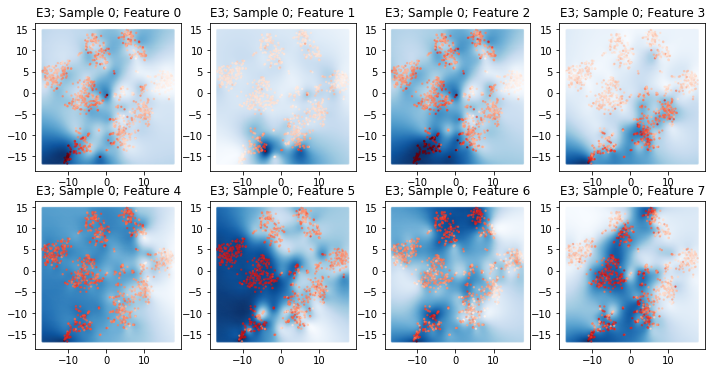

In [107]:
nrow, ncol = 2, 4
fig, axes = plt.subplots(nrow, ncol, figsize = (ncol * 3, nrow * 3))
axes = axes.ravel()

for idx in range(nrow * ncol):
    sample = data_samples_E3[0]
    tsne   = data_tsne_E3[0]
    img    = data_img_E3[0][idx]
    ax     = axes[idx]
    plot_img( ax, tsne, img)
    plot_tsne(ax, tsne, sample, idx_feature = idx, alpha=0.6)
    ax.set_title("E3; Sample 0; Feature " + str(idx))
    
plt.show()

Plot E4

In [91]:
print(data_samples_E4.shape)
print(data_tsne_E4.shape)
print(data_img_E4.shape)

(33, 10000, 14)
(1, 10000, 2)
(1, 1, 128, 128)


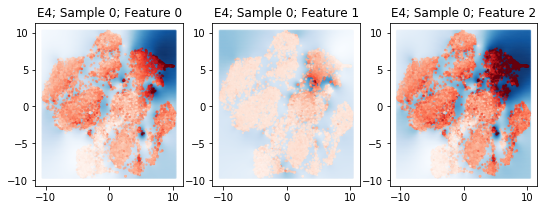

In [109]:
nrow, ncol = 1, 3
fig, axes = plt.subplots(nrow, ncol, figsize = (ncol * 3, nrow * 3))
axes = axes.ravel()

idx    = 0
sample = data_samples_E4[0]
tsne   = data_tsne_E4[0]

img    = data_img_E4_f1[0][0]
ax     = axes[idx]
plot_img( ax, tsne, img)
plot_tsne(ax, tsne, sample, idx_feature = idx, alpha=0.6)
ax.set_title("E4; Sample 0; Feature " + str(idx))

idx    = 1
img    = data_img_E4_f2[0][0]
ax     = axes[idx]
plot_img( ax, tsne, img)
plot_tsne(ax, tsne, sample, idx_feature = idx, alpha=0.6)
ax.set_title("E4; Sample 0; Feature " + str(idx))

idx    = 2
img    = data_img_E4_f3[0][0]
ax     = axes[idx]
plot_img( ax, tsne, img)
plot_tsne(ax, tsne, sample, idx_feature = idx, alpha=0.6)
ax.set_title("E4; Sample 0; Feature " + str(idx))
    
plt.show()

# Run and store the E3 results

In [13]:
!ls /data/deep-learning-group/test_data/flow_EQAPOL/

data_CMV.np	data_SEB.np  tsne_E3sub10.npz
data_Costim.np	markers.np   tsne_img_E3sub10.npz


In [11]:
tmp = samples
samples_std = data_standardization(tmp)

#################################
print("=====  1000  (E3) cells ======")
data_labels_E3sub10, data_samples_E3sub10 = data_subsetting(samples_std, label_groups, k = 1000, num_subsets = 10, verbose = True)
data_tsne_E3sub10 = create_tsne(data_samples_E3sub10, verbose = True)

print("================")
print("check dimension")
print(data_samples_E3sub10.shape)
print(data_labels_E3sub10.shape)
print(data_tsne_E3sub10.shape)

#################################
# output the value
tmp_dir = "/data/deep-learning-group/test_data/flow_EQAPOL/"
fname = "tsne_E3sub10.npz"

# open the file for writing
file_object = open(tmp_dir + fname, 'wb') # wb --- write binary

# write data to the file
np.savez(
    file_object, 
    data_samples = data_samples_E3sub10, 
    data_labels  = data_labels_E3sub10, 
    data_tsne    = data_tsne_E3sub10)

# close the file
file_object.close()

print("The results are stored.")

=====  1000  (E3) cells ======
Data Subsetting...
...Finish
Create t-SNE plots...
	Prepare t-SNE plot of the 0 sample
	Prepare t-SNE plot of the 1 sample
	Prepare t-SNE plot of the 2 sample
	Prepare t-SNE plot of the 3 sample
	Prepare t-SNE plot of the 4 sample
	Prepare t-SNE plot of the 5 sample
	Prepare t-SNE plot of the 6 sample
	Prepare t-SNE plot of the 7 sample
	Prepare t-SNE plot of the 8 sample
	Prepare t-SNE plot of the 9 sample
	Prepare t-SNE plot of the 10 sample
	Prepare t-SNE plot of the 11 sample
	Prepare t-SNE plot of the 12 sample
	Prepare t-SNE plot of the 13 sample
	Prepare t-SNE plot of the 14 sample
	Prepare t-SNE plot of the 15 sample
	Prepare t-SNE plot of the 16 sample
	Prepare t-SNE plot of the 17 sample
	Prepare t-SNE plot of the 18 sample
	Prepare t-SNE plot of the 19 sample
	Prepare t-SNE plot of the 20 sample
	Prepare t-SNE plot of the 21 sample
	Prepare t-SNE plot of the 22 sample
	Prepare t-SNE plot of the 23 sample
	Prepare t-SNE plot of the 24 sample
	Pr

	Prepare t-SNE plot of the 217 sample
	Prepare t-SNE plot of the 218 sample
	Prepare t-SNE plot of the 219 sample
	Prepare t-SNE plot of the 220 sample
	Prepare t-SNE plot of the 221 sample
	Prepare t-SNE plot of the 222 sample
	Prepare t-SNE plot of the 223 sample
	Prepare t-SNE plot of the 224 sample
	Prepare t-SNE plot of the 225 sample
	Prepare t-SNE plot of the 226 sample
	Prepare t-SNE plot of the 227 sample
	Prepare t-SNE plot of the 228 sample
	Prepare t-SNE plot of the 229 sample
	Prepare t-SNE plot of the 230 sample
	Prepare t-SNE plot of the 231 sample
	Prepare t-SNE plot of the 232 sample
	Prepare t-SNE plot of the 233 sample
	Prepare t-SNE plot of the 234 sample
	Prepare t-SNE plot of the 235 sample
	Prepare t-SNE plot of the 236 sample
	Prepare t-SNE plot of the 237 sample
	Prepare t-SNE plot of the 238 sample
	Prepare t-SNE plot of the 239 sample
	Prepare t-SNE plot of the 240 sample
	Prepare t-SNE plot of the 241 sample
	Prepare t-SNE plot of the 242 sample
	Prepare t-S

In [12]:
data_img_E3sub10  = create_img(
    data_tsne_E3sub10, data_samples_E3sub10, 
    verbose = True, verbose_sample = True, verbose_marker = False)

print("================")
print("check dimension")
print(data_samples_E3sub10.shape)
print(data_labels_E3sub10.shape)
print(data_tsne_E3sub10.shape)
print(data_img_E3sub10.shape)


# output the value
tmp_dir = "/data/deep-learning-group/test_data/flow_EQAPOL/"
fname = "tsne_img_E3sub10.npz"

# open the file for writing
file_object = open(tmp_dir + fname, 'wb') # wb --- write binary

# write data to the file
np.savez(
    file_object, 
    data_samples = data_samples_E3sub10, 
    data_labels  = data_labels_E3sub10, 
    data_tsne    = data_tsne_E3sub10,
    data_img     = data_img_E3sub10)

# close the file
file_object.close()

print("The results are stored.")

Create images from t-SNE plot...
	Prepare image of the 0 sample
	Prepare image of the 1 sample
	Prepare image of the 2 sample
	Prepare image of the 3 sample
	Prepare image of the 4 sample
	Prepare image of the 5 sample
	Prepare image of the 6 sample
	Prepare image of the 7 sample
	Prepare image of the 8 sample
	Prepare image of the 9 sample
	Prepare image of the 10 sample
	Prepare image of the 11 sample
	Prepare image of the 12 sample
	Prepare image of the 13 sample
	Prepare image of the 14 sample
	Prepare image of the 15 sample
	Prepare image of the 16 sample
	Prepare image of the 17 sample
	Prepare image of the 18 sample
	Prepare image of the 19 sample
	Prepare image of the 20 sample
	Prepare image of the 21 sample
	Prepare image of the 22 sample
	Prepare image of the 23 sample
	Prepare image of the 24 sample
	Prepare image of the 25 sample
	Prepare image of the 26 sample
	Prepare image of the 27 sample
	Prepare image of the 28 sample
	Prepare image of the 29 sample
	Prepare image of

	Prepare image of the 251 sample
	Prepare image of the 252 sample
	Prepare image of the 253 sample
	Prepare image of the 254 sample
	Prepare image of the 255 sample
	Prepare image of the 256 sample
	Prepare image of the 257 sample
	Prepare image of the 258 sample
	Prepare image of the 259 sample
	Prepare image of the 260 sample
	Prepare image of the 261 sample
	Prepare image of the 262 sample
	Prepare image of the 263 sample
	Prepare image of the 264 sample
	Prepare image of the 265 sample
	Prepare image of the 266 sample
	Prepare image of the 267 sample
	Prepare image of the 268 sample
	Prepare image of the 269 sample
	Prepare image of the 270 sample
	Prepare image of the 271 sample
	Prepare image of the 272 sample
	Prepare image of the 273 sample
	Prepare image of the 274 sample
	Prepare image of the 275 sample
	Prepare image of the 276 sample
	Prepare image of the 277 sample
	Prepare image of the 278 sample
	Prepare image of the 279 sample
	Prepare image of the 280 sample
	Prepare i

In [14]:
tmp = samples
samples_std = data_standardization(tmp)

#################################
print("=====  10000  (E4) cells ======")
data_labels_E4sub10, data_samples_E4sub10 = data_subsetting(samples_std, label_groups, k = 10000, num_subsets = 10, verbose = True)
data_tsne_E4sub10 = create_tsne(data_samples_E4sub10, verbose = True)

=====  10000  (E4) cells ======
Data Subsetting...
...Finish
Create t-SNE plots...
	Prepare t-SNE plot of the 0 sample
	Prepare t-SNE plot of the 1 sample
	Prepare t-SNE plot of the 2 sample
	Prepare t-SNE plot of the 3 sample
	Prepare t-SNE plot of the 4 sample
	Prepare t-SNE plot of the 5 sample
	Prepare t-SNE plot of the 6 sample


KeyboardInterrupt: 

# time each procedure

In [24]:
class Timer:
    def __init__(self):
        self.time1 = 0
        self.time2 = 0
        self.diff  = 0
        
    def start(self):
        self.time1 = time.time()
    
    def stop(self):
        self.time2 = time.time()
        self.diff = self.time2 - self.time1
        
    def report(self, niter = 1):
        val = self.diff / niter
        return val // 3600, val // 60 % 60, val % 60

**Initialize a timer**

In [25]:
timer = Timer()

**time the data standardization**

In [10]:
timer.start()
# ====================================

niter = 2
for _ in range(niter):
    tmp = samples
    tmp = data_standardization(tmp, verbose = True)

samples_std = tmp
# ====================================    
timer.stop()
print(timer.report(niter = niter))
print("=========================")
print("samples.shape    ", samples.shape)
print("samples_std.shape", samples_std.shape)

Data Standardization...
...Finish
Data Standardization...
...Finish
(0.0, 0.0, 2.028380274772644)


**time the data augmentation**

In [11]:
tmp = samples
tmp = data_standardization(tmp)

timer.start()
# ====================================

niter = 2
num_subsets = 10
k = 1000
for _ in range(niter):
    data_labels, data_samples = data_subsetting(tmp, label_groups, k = k, num_subsets = num_subsets, verbose = True)

# ====================================    
timer.stop()
print(timer.report(niter = niter))
print("=========================")
print(data_samples.shape)
print(num_subsets * samples.shape[0])

Data Subsetting...
...Finish
Data Subsetting...
...Finish
(0.0, 0.0, 2.658459424972534)


**time the tsne**

In [12]:
tmp = samples
tmp = data_standardization(tmp)

data_labels, data_samples = data_subsetting(tmp, label_groups, k = 10000, num_subsets = 10)
tmp = data_samples[0:1]

timer.start()
# ====================================
time1 = time.time()
niter = 2

for _ in range(niter):
    data_tsne = create_tsne(tmp, verbose = True)
    
# ====================================    
timer.stop()
print(timer.report(niter = niter))

Create t-SNE plots...
	Prepare t-SNE plot of the 0 sample
...Finish
Create t-SNE plots...
	Prepare t-SNE plot of the 0 sample
...Finish
(0.0, 0.0, 57.94693398475647)


**time the tsne to image**

In [ ]:
tmp = samples
tmp = data_standardization(tmp)

#################################

data_labels_E3, data_samples_E3 = data_subsetting(tmp, label_groups, k = 1000, num_subsets = 1)

tmp = data_samples_E3[0:1]
data_tsne_E3 = create_tsne(tmp)

#################################

data_labels_E4, data_samples_E4 = data_subsetting(tmp, label_groups, k = 10000, num_subsets = 1)

tmp = data_samples_E4[0:1]
data_tsne_E4 = create_tsne(tmp)

In [13]:
tmp = samples
tmp = data_standardization(tmp)

data_labels, data_samples = data_subsetting(tmp, label_groups, k = 1000, num_subsets = 1)

tmp = data_samples[0:1]
data_tsne = create_tsne(tmp)

timer.start()
# ====================================

niter = 2
for _ in range(niter):
    data_img = create_img(data_tsne, tmp, verbose = True, verbose_sample = True, verbose_marker = True)
    
# ====================================    
timer.stop()
print(timer.report(niter = niter))

Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
		interpolating the 1 feature
		interpolating the 2 feature
		interpolating the 3 feature
		interpolating the 4 feature
		interpolating the 5 feature
		interpolating the 6 feature
		interpolating the 7 feature
		interpolating the 8 feature
		interpolating the 9 feature
		interpolating the 10 feature
		interpolating the 11 feature
		interpolating the 12 feature
		interpolating the 13 feature
...Finish
Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
		interpolating the 1 feature
		interpolating the 2 feature
		interpolating the 3 feature
		interpolating the 4 feature
		interpolating the 5 feature
		interpolating the 6 feature
		interpolating the 7 feature
		interpolating the 8 feature
		interpolating the 9 feature
		interpolating the 10 feature
		interpolating the 11 feature
		interpolating the 12 feature
		interpolating the 13 feature
...Finish
(0.0

In [75]:
timer.start()
# ====================================

niter = 2
for _ in range(niter):
    data_img = create_img2(data_tsne, tmp, verbose = True, verbose_sample = True, verbose_marker = True)
    
# ====================================    
timer.stop()
print(timer.report(niter = niter))

Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
		interpolating the 1 feature
		interpolating the 2 feature
		interpolating the 3 feature
		interpolating the 4 feature
		interpolating the 5 feature
		interpolating the 6 feature
		interpolating the 7 feature
		interpolating the 8 feature
		interpolating the 9 feature
		interpolating the 10 feature
		interpolating the 11 feature
		interpolating the 12 feature
		interpolating the 13 feature
...Finish
Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
		interpolating the 1 feature
		interpolating the 2 feature
		interpolating the 3 feature
		interpolating the 4 feature
		interpolating the 5 feature
		interpolating the 6 feature
		interpolating the 7 feature
		interpolating the 8 feature
		interpolating the 9 feature
		interpolating the 10 feature
		interpolating the 11 feature
		interpolating the 12 feature
		interpolating the 13 feature
...Finish
(0.0

In [77]:
data_tsne.shape

(1, 10000, 2)

In [ ]:
timer.start()
# ====================================

niter = 2
for _ in range(niter):
    data_img = create_img2(data_tsne, tmp, verbose = True, verbose_sample = True, verbose_marker = True)
    
# ====================================    
timer.stop()
print(timer.report(niter = niter))

Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature


In [70]:
data_tsne.shape

(1, 1000, 2)

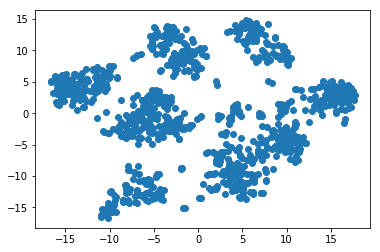

In [72]:
plt.scatter(data_tsne[0,:,0], data_tsne[0,:,1])
plt.show()

/local_data/env-py3/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/local_data/env-py3/lib/python3.6/site-packages/numpy/ma/core.py:710: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


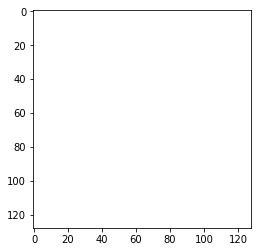

In [69]:
plt.imshow(data_img[0, 0])
plt.show()

In [17]:
data_tsne[:, :, 1].shape

SyntaxError: invalid syntax (<ipython-input-17-2d50ead92aa9>, line 1)

In [ ]:
tmp = samples
tmp = data_standardization(tmp)

data_labels, data_samples = data_subsetting(tmp, label_groups, k = 10000, num_subsets = 1)

tmp = data_samples[0:1]
data_tsne = create_tsne(tmp)

timer.start()
# ====================================

niter = 2
for _ in range(niter):
    data_img = create_img(data_tsne, tmp, verbose = True, verbose_sample = True, verbose_marker = True)
    
# ====================================    
timer.stop()
print(timer.report(niter = niter))

Create images from t-SNE plot...
	Prepare image of the 0 sample
		interpolating the 0 feature
		interpolating the 1 feature


In [ ]:
tmp = samples
tmp = data_standardization(tmp, verbose = 0)
data_labels, data_samples = data_augmentation(
    tmp, label_groups, k = 5000, num_subsets = 10, verbose = 0)

tmp = data_samples[0:1]
data_tsne = create_tsne(tmp, verbose = 0)

time1 = time.time()
data_img = create_img(data_tsne, tmp)
time2 = time.time()

print(cal_time((time2 - time1)))

Create images from t-SNE plot...
    Prepare image of the 0 sample
        interpolating the 0 feature
        interpolating the 1 feature
        interpolating the 2 feature
        interpolating the 3 feature


In [ ]:
print("================")
print("check dimension")
print(data_samples.shape)
print(data_labels.shape)
print(data_tsne.shape)
print(data_img.shape)

# Run the code and store the results

In [ ]:
tmp = samples
tmp = data_standardization(tmp)

data_labels, data_samples = data_augmentation(tmp, label_groups, k = 10000, num_subsets = 10)

tmp = data_samples
data_tsne = create_tsne(tmp)

########################################
# output the value
res_dir = "/data/deep-learning-group/test_data/flow_EQAPOL/"
file_name = "tsne_eqapol.npz"

# open the file for writing
file_object = open(res_dir + file_name, 'wb') # wb --- write binary

# write data to the file
np.savez(
    file_object, 
    data_samples = data_samples, 
    data_labels  = data_labels, 
    data_tsne    = data_tsne)

# close the file
file_object.close()

print("The tsne results are stored.")

In [ ]:
data_img = create_img(data_tsne, tmp, verbose2 = False)

print("================")
print("check dimension")
print(data_samples.shape)
print(data_labels.shape)
print(data_tsne.shape)
print(data_img.shape)

# output the value
res_dir = "/data/deep-learning-group/test_data/flow_EQAPOL/"
file_name = "data_img.npz"

# open the file for writing
file_object = open(res_dir + file_name, 'wb') # wb --- write binary

# write data to the file
np.savez(
    file_object, 
    data_samples = data_samples, 
    data_labels  = data_labels, 
    data_tsne    = data_tsne,
    data_img     = data_img)

# close the file
file_object.close()

print("The img results are stored.")